# Right-sizing your Amazon SageMaker Endpoints

__Disclaimer__:
* To run this notebook, you are recommended to use a ml.m5.4xlarge or a larger instance-type to avoid running into CPU limit errors for load testing. 

## Introduction

This notebook is intended to guide you through the process of choosing the correct instance type for model serving depending on the following criteria:
1. Number of requests per second
2. Endpoint costs.

By running part of this notebook, you will run the load tests and identify the optimal instance type. These load tests are executed with the [Locust](https://locust.io/) load testing framework. Locust allows you to run load tests in parallel until the instance fails for each instance type that you wants to compare, thus providing a comprehensive view of performance vs cost for each instance type. 

The load testing to identify the best fit instance can be carried out via two different approaches. The first approach runs a set of automatic tests to build a performance map of all candidate instance types you specify. The second approach lets you take a more hands-on aproach to iterate manually.

This notebook demonstrates the endpoint instance type optimization for the Wide ResNet-50 Image Classification model from the AWS Marketplace. Note that you may however, tweak this notebook and use it to test other ML models too.

**Note** - The cost of running this notebook depends on the model you use and its corresponding acceptable instance types. Although the ML model configured in this notebook does not have any software costs, other ML Models from AWS Marketplace may incur additional software costs. This notebook will cost between 30-40$ USD to deploy and test the endpoints.


### Table of Contents

0. [Prerequisites](#prereq)

1. [Step 1: Setting up the model and endpoint](#setup-model-endpoint)

    1. [Step 1.1: Set up environment](#env-setup)
    2. [Step 1.2: Identify and prepare data for load testing](#data-setup)
    3. [Step 1.3: Subscribe to the PyTorch ResNet50 ML Model from AWS Marketplace](#ml-setup)
    4. [Step 1.4: Set up Lambda function and API Gateway](#infra-setup)
    
2. [Step 2: Load Testing](#load-testing)

    1. [Step 2.1: Comprehensive testing](#comprehensive-testing)
        1. [Step 2.1.1: Deploy endpoints](#deploy-ep)
        2. [Step 2.1.2: Test endpoints with a sample paylod](#check-eps)
        3. [Step 2.1.3: Execute load tests](#run-load-tests)
        4. [Step 2.1.4: Performance vs price plot](#plot)
        5. [Step 2.1.5: Finalize Configuration](#recommendations)
    
    2. [Step 2.2: Semi-automatic testing](#semi-aut-testing)
        1. [Step 2.2.1: First iteration](#first-iteration)
        2. [Step 2.2.2: Second iteration](#second-iteration)
        
3. [Step 3: Clean up Resources](#clean-up)

### Prerequisites
<a id='prereq'></a>

In [1]:
# Install Locust library for load testing
import sys
!{sys.executable} -m pip install locust==1.2.3

     |████████████████████████████████| 658 kB 31.6 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 10.0 MB/s eta 0:00:01
  Created wheel for Flask-BasicAuth: filename=Flask_BasicAuth-0.2.0-py3-none-any.whl size=4226 sha256=33af8a7dbec34a51865fc0aa200fa189887b7f900882b4554bc06667c43fbbd4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c1/d1/c8/8907e9d50e80655218f9e50d91d3516310731063fbdd229f21
Successfully built Flask-BasicAuth
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


1. If you'd like to perform load tests for your custom algorithm and model, you should already have a model registered on Amazon SageMaker, and have the model ARN ready.
2. You will need **sufficient account limits** to create all endpoints you'd like to test. This notebook tests GPU instances, including ml.p3.2xlarge and ml.g4dn.xlarge instances. If you do not have the sufficient instance count limits, you can request account quotas updates [here](https://aws.amazon.com/premiumsupport/knowledge-center/ec2-instance-limit/), or edit the instance types accordingly in the first cell under the ["Comprehensive testing"](#comprehensive-testing) section. To execute this notebook as-is, you will need the following limits - 

    - ml.c5.xlarge - 1
    - ml.c5.2xlarge - 1
    - ml.m5.large - 1
    - ml.m5.xlarge - 1
    - ml.p2.xlarge - 1
    - ml.p3.2xlarge - 1
    - ml.g4dn.xlarge -3

In [7]:
from sagemaker import get_execution_role

print(get_execution_role())

arn:aws:iam::256275036402:role/service-role/AmazonSageMaker-ExecutionRole-20210316T120748


3. **Amazon SageMaker execution role with _Administrator_ permissions on the account**, or the following AWS managed policies:
    - AmazonSageMakerFullAccess (this policy is attached by default to notebook execution roles). 
    - IAMFullAccess
    - AmazonAPIGatewayAdministrator
    - AWSPriceListServiceFullAccess
    - AWSLambda_FullAccess
    
If you are unsure, go to the IAM console [here](https://console.aws.amazon.com/iam/home?region=us-east-1#/roles), search for the notebook execution role (the role ARN is printed in the cell above), and attach the above policies using the 'Attach policies' button. 

<img src="assets/IAMRole.png" width="700">

## Step 1: Setting up the model and endpoint

<a id='setup-model-endpoint'> </a>

In this section, you will load the model from the AWS Marketplace and host it to real-time endpoints on Amazon SageMaker based on suggested instance types. You will also set up an Amazon API Gateway and AWS Lambda function to trigger the endpoints for load testing. If you are testing on a custom model, skip to the [Infrastructure Setup](#infra-setup) section to set up the API Gateway.

### Step 1.1: Set up environment
<a id='env-setup'></a>

In this section, you will import the necessary libraries and declare variables.

In [8]:
%load_ext autoreload
%autoreload 2

# Import all necessary libraries
import os
import re
import json
import time
import boto3
import random
import requests
import base64
import sagemaker
import pandas as pd

from pprint import pprint
from IPython.display import Image 
from sagemaker import ModelPackage
from sagemaker import get_execution_role

# Import from helper functions
from api_helper import create_infra, delete_infra
from sagemaker_helper import deploy_endpoints, clean_up_endpoints
from load_test_helper import run_load_tests, generate_plots, get_min_max_instances, generate_latency_plot

# Define the boto3 clients/resources that will be used later on
sm_client = boto3.client('sagemaker')

# Define session variables
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
account_id = sagemaker_session.account_id()
role = get_execution_role()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1.2: Identify and prepare data for load testing
<a id='data-setup'></a>

#### Dataset

The **Pytorch ResNet50** ML model used by this notebook has been trained on the [ImageNet](http://www.image-net.org/about) dataset, which consists of around 100,000 image classes, with 1000 images each. To run the load testing on the ML model, you will use a sample image attached with this repository. In next cell, you will load and view the image.

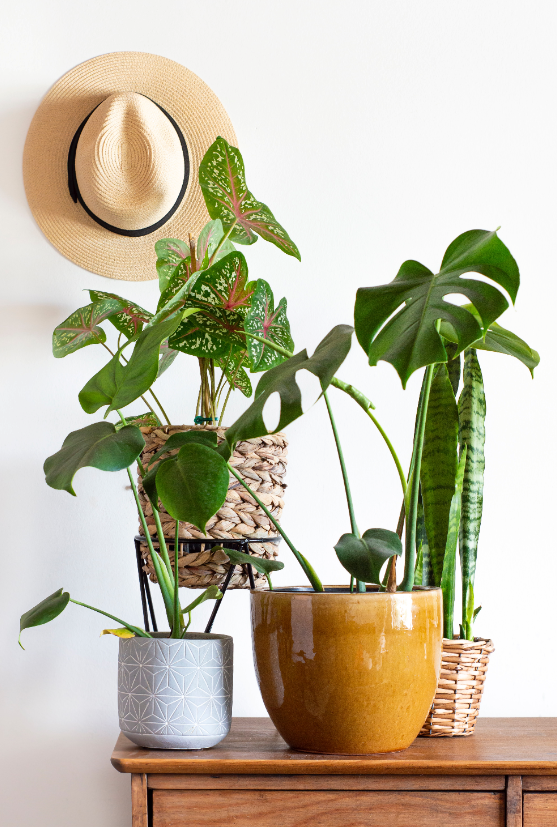

In [9]:
# Images are unzipped automatically to the val2017/ folder
input_file = "plants.jpg"
# Load and display image
pil_img = Image(filename=input_file)
display(pil_img)

### Step 1.3: Subscribe to the PyTorch ResNet50 ML Model from AWS Marketplace
<a id='ml-setup'></a>

Next, you will subscribe to the model package from the AWS Marketplace and create a dynamic model which you will configure for the load testing.

In this notebook, you will use the **Pytorch ResNet50** models available in the AWS Marketplace [here](https://aws.amazon.com/marketplace/ai/configuration?productId=f2590bef-2833-45ce-951b-55a28349e14f&ref=sa_campaign_ds_vj). Since this is a demonstration notebook, it covers both, a CPU and GPU ML model.


1. Open the following ML models in separate tabs. Note that both ML models have application/x-image as the mime type.
    * [Wide ResNet 50 - CPU](https://aws.amazon.com/marketplace/pp/prodview-dnc7grtzdiihs) 
    * [Wide ResNet 50 - GPU](https://aws.amazon.com/marketplace/pp/prodview-v2r2tm2tepa3o) 
2. For both the ML models follow the following process:
    2. Read the **Highlights** section and then **product overview** section of the listing.
    3. View **usage information** and then **additional resources**.
    4. Note the supported instance types.
    5. Next, click on **Continue to subscribe**.
    6. Review **End user license agreement**, **support terms**, as well as **pricing information**.
    7. **"Accept Offer"** button needs to be clicked if your organization agrees with EULA, pricing information as well as support terms.
    8. Choose **Continue to Configuration**.
    9. Copy the **Product Arn** and specify the same in the following cell

In [56]:
# Note down the model ARN from AWS Marketplace
# The sample notebook is developed in the us-east-1 region. If you are working in a different region, make sure to get the right product Arn.
model_arn_cpu = "arn:aws:sagemaker:us-east-1:865070037744:model-package/pytorch-ic-wide-resnet50-2-cpu-6a1d8d24bbc97d8de3e39de7e74b3293"
model_arn_gpu = "arn:aws:sagemaker:us-east-1:865070037744:model-package/pytorch-ic-wide-resnet50-2-gpu-445fe358cb7a3a0d92861174cf00c113"

In [57]:
# Get content type for invoking endpoint
content_type = 'application/x-image'

Next, you will create dynamic ML models from the model packages specified. 

In [60]:
# Create CPU and GPU models on Amazon SageMaker from the given model ARNs
cpu_model = ModelPackage(
    role=role,
    model_package_arn=model_arn_cpu,
    sagemaker_session=sagemaker_session
)

gpu_model = ModelPackage(
    role=role,
    model_package_arn=model_arn_gpu,
    sagemaker_session=sagemaker_session
)

At this point, you have created two Amazon SageMaker models, for the CPU and GPU versions. The Amazon SageMaker endpoints will not be created yet, since deploying the endpoints is part of the process that will be automated based on your choice of instance types. The next step for you is to configure the threshold limits.

In [13]:
# Specify the minimum and maximum number of requests for your model here
min_requests_per_second = 50
max_requests_per_second = 110

### Step 1.4: Set up Lambda Function and an API Gateway
<a id='infra-setup'></a>

**Prerequisite** - If you are using your own model, ensure that it is loaded on Amazon SageMaker to be hosted on an endpoint before proceeding with this step. 

To test the functioning of the model endpoint in a production environment, you will implement an API Gateway and an AWS Lambda function to direct the requests to the model endpoint. The infrastructure approach followed is the same as described in the blog [Call an Amazon SageMaker model endpoint using Amazon API Gateway and AWS Lambda](https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/).

The blog suggests the following architecture:
1. An Amazon API Gateway that receives the prediction requests
2. A AWS Lambda function that sits behind the API Gateway and calls the endpoint for requests

As a complimentary element of this infrastructure, you will also need to account for the roles and policies that allow the resources to call the required AWS services.

To successfully set up the suggested infrastructure, you will also need corresponding IAM roles and policies that allow the resources to call the required AWS services. To make it easy for you to set up the infrasture suggested for the load test, you can use the `create_infra()` helper function. The function outputs the API gateway URL that will be used later on to request the predictions via POST requests.

__Note:__
If you are using your custom model, edit the lambda_index function to update the right payload (input data and content types).

In [14]:
%%writefile lambda_index.py

import os
import boto3
import json
import base64
from botocore.config import Config
from botocore.exceptions import ClientError


# SageMaker runtime is used to invoke the endpoint
runtime = boto3.client(
    'runtime.sagemaker',
    config = Config(
        connect_timeout = 30,
        read_timeout = 60,
        retries={'max_attempts': 20}
    )
)


def lambda_handler(event, context):
    """
    Invokes SageMaker endpoint and return response
    
    This function invokes a given SageMaker endpoint and returns
    the endpoint response. SageMaker error codes are sent back for
    mapping by API gateway if the invocation results in an error.
    
    Inputs:
    data - imageb64 object to be classified
    endpoint - name of the endpoint to invoke
    
    Output:
    predicted response/error code.
    """
    
    # Load data sent through API gateway
    data = json.loads(json.dumps(event))
    payload = data['data']
    endpoint_name = data['endpoint']
    image = base64.b64decode(payload)
    try:
        # Invoke endpoint
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/x-image",
            Accept="application/json",
            Body=image)
    
        # Read success/failure response
        response_code = response['ResponseMetadata']['HTTPStatusCode']
        
        return response['Body'].read().decode('utf-8')
    
    except ClientError as e:
       
        # Return failure code
        if e.response['Error']['Code'] == 'ModelError':
            response = json.loads(e.response['OriginalMessage'])
            return {'statusCode': response["code"], 'body': response["type"]}

Writing lambda_index.py


In [61]:
%%time
# This function takes a few seconds to deploy the full architecture
# including a lambda function and an API gateway
# For easy identification of resources, specify a prefix for the application
project_name = "right-size-endpoints"  
api_url = create_infra(project_name, account_id, region)

# note the REST API id for clean up
rest_api_id = api_url.replace('https://', '').split('.')[0]

API GATEWAY URL: url = https://yzlgfq6ek4.execute-api.us-east-1.amazonaws.com/dev/ImageClassifier
CPU times: user 55.8 ms, sys: 3.83 ms, total: 59.6 ms
Wall time: 11.6 s


## Step 2: Load testing
<a id='load-testing'></a>

In the second section, deploy the model in the form of multiple Amazon SageMaker Endpoints, to perform load testing. 

There are two ways of executing this notebook - 
- **Comprehensive testing**: In this section, you will deploy the supported instance types of the model. You will then perform testing across all supported instance types and run the load tests until the endpoint fails for each instance type. In this notebook, we "fail" an endpoint when the instance cannot respond to 1% of the incoming requests. Finally, you will plot performance in maximum requests per second against the price (assuming single instance endpoints), so that the you can make an informed decision on choosing the right instance. 

- **Semi-automatic testing**: If you are familiar with Amazon SageMaker instances and have a shortlisted set of instance types and number of instances that you would like to test, proceed to the [Semi-Automatic Testing](#semi-aut-testing) section, skipping the comprehensive testing.

*Note: If you like to increase or decrease the error rate, you can edit it in line 15 of `locust_file.py`*

### Step 2.1: Comprehensive testing
<a id='comprehensive-testing'></a>

This section creates an endpoint each for each of the supported instance types. From the model configuration page [here](https://aws.amazon.com/marketplace/pp/prodview-dnc7grtzdiihs) under the 'Pricing' tab, you can obtain the supported instance types. They are listed below:

__CPU__
- ml.c5.xlarge
- ml.c5.2xlarge
- ml.m5.large
- ml.m5.xlarge

__GPU__
- ml.p2.xlarge
- ml.p3.2xlarge
- ml.g4dn.xlarge

Next, you will create multiple endpoints, one of each instance type, and keep the instance count at 1 (as specified in the following configuration). 

### Step 2.1.1  Deploy endpoints
<a id='deploy-ep'></a>

In [17]:
# Update with the supported instances if running for a different model

endpoints_dict = [    
    {"instance_type": "ml.c5.xlarge",  "instance_count": 1},
    {"instance_type": "ml.c5.2xlarge", "instance_count": 1},
    {"instance_type": "ml.m5.large",  "instance_count": 1},
    {"instance_type": "ml.m5.xlarge", "instance_count": 1},
    {"instance_type": "ml.p2.xlarge", "instance_count": 1},
    {"instance_type": "ml.p3.2xlarge",  "instance_count": 1},
    {"instance_type": "ml.g4dn.xlarge", "instance_count": 1},
]

In [19]:
%%time
# The endpoints are created synchronously, so this code will take
# a few minutes to execute
endpoints = deploy_endpoints(endpoints_dict, cpu_model, gpu_model)


Endpoint endpoint-ml-p3-2xlarge-x1 already exists.
endpoint-ml-p3-2xlarge-x1

Deploying to endpoint-ml-g4dn-xlarge-x1...

Endpoint endpoint-ml-m5-large-x1 already exists.
endpoint-ml-m5-large-x1

Endpoint endpoint-ml-c5-2xlarge-x1 already exists.

Endpoint endpoint-ml-m5-xlarge-x1 already exists.
endpoint-ml-c5-2xlarge-x1
endpoint-ml-m5-xlarge-x1

Endpoint endpoint-ml-c5-xlarge-x1 already exists.
endpoint-ml-c5-xlarge-x1

Endpoint endpoint-ml-p2-xlarge-x1 already exists.
endpoint-ml-p2-xlarge-x1
-----------------!endpoint-ml-g4dn-xlarge-x1
CPU times: user 275 ms, sys: 29.5 ms, total: 305 ms
Wall time: 8min 32s


### Step 2.1.2: Test endpoints with a sample payload
<a id='test-eps'></a>

Now that there are multiple endpoints, let's test all the endpoints to make sure they are running without any errors. A HTTP 200 response for the requests ensures that the model is working as expected. 

In [22]:
# Create an Image object by reading the image
with open(input_file, 'rb') as f:
    image = f.read()

In [26]:
# Run the lambda function once for each endpoint
# and check for HTTP 200 response
for ep in endpoints:
    # Create a payload for Lambda - input variables are the image and endpoint name
    payload = {
        'data': str(image),
        'endpoint': ep}

    response = requests.post(api_url, json=payload)
    print(f"Endpoint {ep}: {response}")

Endpoint endpoint-ml-p3-2xlarge-x1: <Response [200]>
Endpoint endpoint-ml-m5-large-x1: <Response [200]>
Endpoint endpoint-ml-c5-2xlarge-x1: <Response [200]>
Endpoint endpoint-ml-m5-xlarge-x1: <Response [504]>
Endpoint endpoint-ml-c5-xlarge-x1: <Response [200]>
Endpoint endpoint-ml-p2-xlarge-x1: <Response [200]>
Endpoint endpoint-ml-g4dn-xlarge-x1: <Response [200]>


### Step 2.1.3: Execute load tests
<a id='run-load-tests'></a>

Now, to run the load tests, you will execute the `run_load_tests` function that calls a short bash script that runs locust.

To run the tests, you will just need to pass the list of endpoints to test to the function `run_load_tests()`. The load test generates multiple comma separated files (.csv) with the test results and store them in a folder with the name `results-YYYY-MM-DD-HH-MM-SS`. Inside this folder you can find the individual test results for each endpoint instance.

In [ ]:
# View the run_locust file
!cat run_locust.sh

__Run_locust.sh breakdown__

The `run_locust.sh` file takes in endpoint name and the created API gateway URL as inputs and invokes the load test. 

The `env` prefix specifies environment variables that are sent to the locust file. Since we're testing multiple endpoints, send the endpoint name as a variable.

`locust -f locust_file.py` runs the load tests. Refer to the file for details on how the load testing is conducted.

`--headless` runs the test without a web UI. Refer [here](https://docs.locust.io/en/stable/running-locust-without-web-ui.html) for documentation.

`--csv` specifies a prefix to store the test results. Here, specify the endpoint name for easy identification.

`-u` specifies the number of users to spawn.

`-r` specifies the spawn rate.

`--host` specifies the endpoint URL to test.


For all available confiuration options, refer to the [Locust documentation.](https://docs.locust.io/en/stable/configuration.html)

In [27]:
%%time
# This cell runs the load tests on all endpoints. Grab a cup of coffee and wait for it to complete!

# NOTE: If you are using a smaller instance than a ml.m5.4xlarge, this cell might take from
# minutes to hours to run. On the ml.m5.xlarge instance for the given endpoints, this took 
# about 30 minutes.

# You can also test the invocation metrics on the CloudWatch console
results_folder = run_load_tests(api_url, endpoints)


Load testing endpoint-ml-p3-2xlarge-x1...
Organizing endpoint-ml-p3-2xlarge-x1 result files...

Load testing endpoint-ml-m5-large-x1...
Organizing endpoint-ml-m5-large-x1 result files...

Load testing endpoint-ml-c5-2xlarge-x1...
Organizing endpoint-ml-c5-2xlarge-x1 result files...

Load testing endpoint-ml-m5-xlarge-x1...
Organizing endpoint-ml-m5-xlarge-x1 result files...

Load testing endpoint-ml-c5-xlarge-x1...
Organizing endpoint-ml-c5-xlarge-x1 result files...

Load testing endpoint-ml-p2-xlarge-x1...
Organizing endpoint-ml-p2-xlarge-x1 result files...

Load testing endpoint-ml-g4dn-xlarge-x1...
Organizing endpoint-ml-g4dn-xlarge-x1 result files...
Load testing complete!
CPU times: user 22.1 ms, sys: 28.6 ms, total: 50.7 ms
Wall time: 7min 38s


**Background on Locust load tests**

The `run_load_tests` function performs load tests and organizes the resulting files into a single folder. Locust saves up to four files for each load test with the following suffixes, similar to the directory structure below.

```
├── results-<timestamp>
│   ├── <endpoint-name>
│   │   ├── <endpoint-name>_failures.csv
│   │   ├── <endpoint-name>_stats.csv
│   │   └── <endpoint-name>_stats_history.csv
│   │   └── <endpoint-name>_exceptions.csv (optional)
│   ├── <endpoint-name> ...
```
The first two files contain the failures and stats for the whole test run, with a row for every stats entry and an aggregated row. The stats history will get new rows with the current (10 seconds sliding window) stats appended during the whole test run. You can find more information on the files and how to increase/decrease the interval of writing stats in the [documentation](https://docs.locust.io/en/stable/retrieving-stats.html).

In the next section, plot the maximum number of requests per second handled by each endpoint. You are also recommended to explore the files generated to check for exceptions, failures, users/requests generated etc.

### Step 2.1.4: Performance vs price plot
<a id='plot'></a>

AWS constantly updates instance prices to provide best value to our customers. The Price List Service API (AKA the Query API) and AWS Price List API (AKA the Bulk API) enables you to query for the prices of AWS services using either JSON (with the Price List Service API) or HTML (with the AWS Price List API). To query the instance prices in real time, your Amazon SageMaker execution role must have permissions to access the service (refer to the [Prerequisites](#prereq) section)

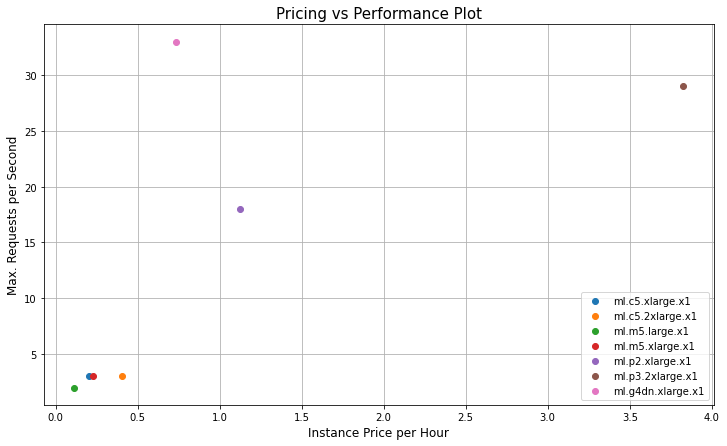

In [28]:
# Plot your results in a single chart to compare instance types
# Set sep_cpu_gpu=True if you want the results plotted in two separate
# graphs for the CPU and GPU instances
results = generate_plots(endpoints, endpoints_dict, results_folder, sep_cpu_gpu=False)

**Load test analysis**
1. The GPU instances perform significantly better for image classification problems, with the least metric at 25 requests per second for USD1.125 per hour ( ml.p2.xlarge instance), versus the most expensive CPU providing around 4 requests per second at USD0.40 per hour (USD2.80 for 25 requests per second, or 2.5 times more expensive).

2. Within the GPU instances, the `ml.g4dn.xlarge` instance is the industry's most cost-effective GPU instance for deploying machine learning models that are graphics-intensive such as image classification, object detection etc. At USD0.70 an hour, it performs twice as better as the next cheaper option, the `ml.p2.xlarge`. 

3. Depending on your requests per second (10 rps or lower versus 50 rps or more), you can choose the CPU or the GPU option. If you go the GPU route, the G4 instance clearly emerges the winner. In the next section, we will programmatically obtain the recommended instance type and autoscaling configuration.

__Optional: View latency metrics__

Optionally, if latency is what you desire, you can also view the average, minimum and maximum response times for each endpoint using the `generate_latency_plot` function from the helper file. 

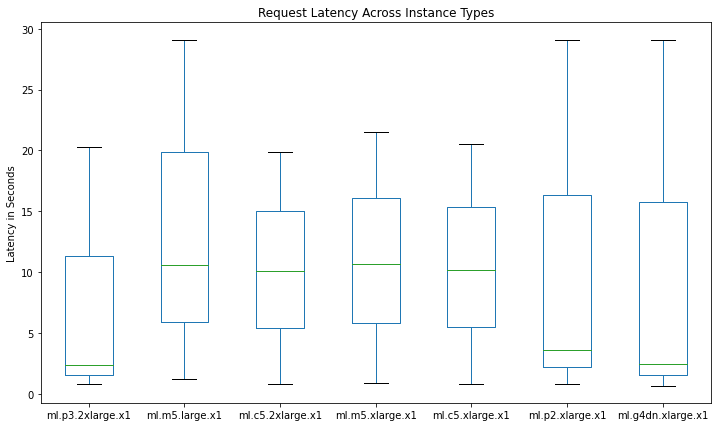

In [29]:
generate_latency_plot(endpoints, results_folder)

**Latency metrics analysis**

The minimum response times stay at below one second for all endpoints regardless of the instance type. However, the average response time is the least (quickest) for the three GPU isntances, with the `ml.g4dn.xlarge` and `ml.p3.2xlarge` having the lowest average response times. 

**Note** - The response time includes model processing time and the API Gateway/Lambda processing time. If a faster response is required for your application, you can use the Locust result file to examine the response times and choose accordingly. 

### Step 2.1.5 Finalize configuration
<a id='recommendations'></a>

Now that you are done with the "grid search" to run all possible endpoints, you can decide on the final endpoint configuration for your use case based on the number of average and maximum requests per second expected for your application.

In the following cell, enter the minimum and maximum requests and then run the remaining section to print the recommended instances for autoscaling. If your application or endpoint gets spiky loads, it is a good idea to configure an auto-scaling configuration. 

For other best practices on ML deployment, see [Deployment Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/best-practices.html).

In [30]:
# Get suggestions for a specific payload

# This function calculates the number of instances based on linear scaling
# and returns the suggested instance type and counts
phase2_endpoints_dict = get_min_max_instances(results, min_requests_per_second, max_requests_per_second)

# Print recommended number of instances based on linear scaling
print("Recommended endpoint configuration for the specified number of requests: ")
print("________________________________________________________________")
print(f"Instance Type: {phase2_endpoints_dict[0]['instance_type']}")
print(f"Minimum Instance Count: {phase2_endpoints_dict[0]['instance_count']}")
print(f"Maximum Instance Count: {phase2_endpoints_dict[1]['instance_count']}")

Recommended endpoint configuration for the specified number of requests: 
________________________________________________________________
Instance Type: ml.g4dn.xlarge
Minimum Instance Count: 2
Maximum Instance Count: 3


The function assumes linear scaling while calculating the minimum and maximum number of instances needed to serve your expected requests per second. The code calculates the price for each instance type and instance count, and returns the least expensive option. 

Test the endpoints with the given instance count configurations to ensure that they can serve your requirements.


Deploying to endpoint-ml-g4dn-xlarge-x3...

Endpoint endpoint-ml-g4dn-xlarge-x2 already exists.
endpoint-ml-g4dn-xlarge-x2
-----------------!endpoint-ml-g4dn-xlarge-x3

Load testing endpoint-ml-g4dn-xlarge-x2...
Organizing endpoint-ml-g4dn-xlarge-x2 result files...

Load testing endpoint-ml-g4dn-xlarge-x3...
Organizing endpoint-ml-g4dn-xlarge-x3 result files...
Load testing complete!


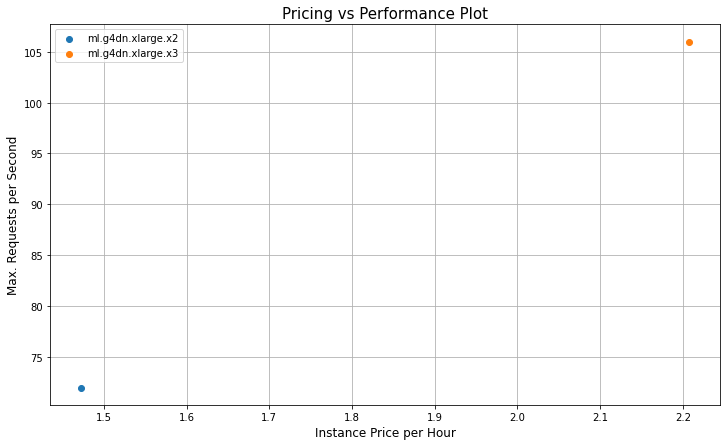

,Price per Hour,Max Requests per Second
ml.g4dn.xlarge.x2,1.472,72
ml.g4dn.xlarge.x3,2.208,106


In [33]:
# Optional: test the instances
phase2_endpoints = deploy_endpoints(phase2_endpoints_dict, cpu_model, gpu_model)
phase2_results_folder = run_load_tests(api_url, phase2_endpoints)
generate_plots(phase2_endpoints, phase2_endpoints_dict, phase2_results_folder, sep_cpu_gpu=False)

Amazon provides you with the ability to automaticaly scale endpoints for your hosted models (autoscaling), i.e., dynamically adjusts the number of instances in response to changes in your workload. When workload increases, autoscaling provisions more instances, and when workload decreases, it removes unnecessary instances so you don't pay for instances that you aren't using.

The main components of an autoscaling policy are - 
1. A target metric - an Amazon CloudWatch metric that is monitored to determine if and when to scale
2. Minimum and maximum capacity - minimum and maximum number of instances (provided in the cell above)
3. Cool down period - time, in seconds, after a scale-in or scale-out activity completes before another scale-out activity can start
4. IAM policy and role to allow Amazon SageMaker to configure autoscaling.

Next, you can update the **min_capacity** and the **max_capacity** you identified in the preceding cell, and adjust the target value, scale in and scale out cool down values in the following configuration. -
```
resource_id='endpoint/' + endpoint_name + '/variant/' + 'AllTraffic'

client = boto3.client('application-autoscaling')

response = client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=5, # obtained from load testing
    MaxCapacity=7
)

response = client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        # update target value, scale in and scale out cool down values as per your requirements
        'TargetValue': 1000.0, # The target value for the metric (in minutes)
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance', 
        'ScaleInCooldown': 600,  # wait 600 seconds before terminating additional instances
        'ScaleOutCooldown': 300 # wait 300 seconds before adding new instances
    }
)
```

For more information, see [Automatically Scale Amazon SageMaker Models](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html).

### Step 2.2: Semi-automatic testing
<a id='semi-aut-testing'></a>

As commented previously, the semi-automatic testing is intended for a user more experienced with Amazon Sagemaker, and who perhaps has interest on running the iteration process of finding the best instance, manually.

To be able to run this, you need to know, or have an idea, of what the maximum and average requests per second your endpoint will be serving. This is a key starting point to be able to use the functionality of this notebook.

As a rule of thumb, test the following two different instance types first, with a single instance of each:

1. The "most expensive" CPU that can host your model (in the sense of cost per hour).
2. The "cheapest" GPU that can host your model.

Then, use your minimum and maximum requests per second goal (rps) that you will need to handle, throughout the decision process below.


**NOTE**: The idea behind this approach is to identify first what type of instance might suit you better. 

The possible outcome results of this first iteration are as follows:

1. If your target rps is above the max rps achieved by a single instance of the cheapest available GPU, it is possible that you will have either to use a more expensive GPU or multiple instances of the cheapest one. --> In this scenario, it is very likely that the CPU instances might not be the best option (in some cases you will have to launch too many CPUs to match the performance of a single GPU, for a higher price).

<img src="assets/semi-auto-scenario1.png" width="250">

2. If your target rps are below the max rps achieved by a single instance of the most expensive CPU, it is possible that you will be able to use a cheaper CPU instance, or just stay with the one you tested (depending on the target rps vs the max rps achieved).  --> In this scenario, it is very likely that the GPU instances might not be the best option.

<img src="assets/semi-auto-scenario2.png" width="250">

3. If your target rps are between the max rps achieved by the cheapest GPU and the most expensive CPU, then you can evaluate from a cost perspective what might be the best, either use multiple CPU instances (assuming linear scaling), or using a single GPU.

<img src="assets/semi-auto-scenario3.png" width="250">


### Step 2.2.1: First iteration
<a id='first-iteration'></a>

For the model that we will be using (**Pytorch ResNet50**), the most expensive CPU based instance is the `ml.c5.2xlarge` and the cheapest GPU based instance is `ml.g4dn.xlarge`. Deploy the model to these two instances.

In [36]:
sat_endpoints_dict = [
    {"instance_type": "ml.c5.2xlarge", "instance_count": 1},
    {"instance_type": 'ml.g4dn.xlarge',  "instance_count": 1}
]


Deploying to endpoint-ml-g4dn-xlarge-x1...

Endpoint endpoint-ml-c5-2xlarge-x1 already exists.
endpoint-ml-c5-2xlarge-x1
-------------------!endpoint-ml-g4dn-xlarge-x1

Load testing endpoint-ml-c5-2xlarge-x1...
Organizing endpoint-ml-c5-2xlarge-x1 result files...

Load testing endpoint-ml-g4dn-xlarge-x1...
Organizing endpoint-ml-g4dn-xlarge-x1 result files...
Load testing complete!


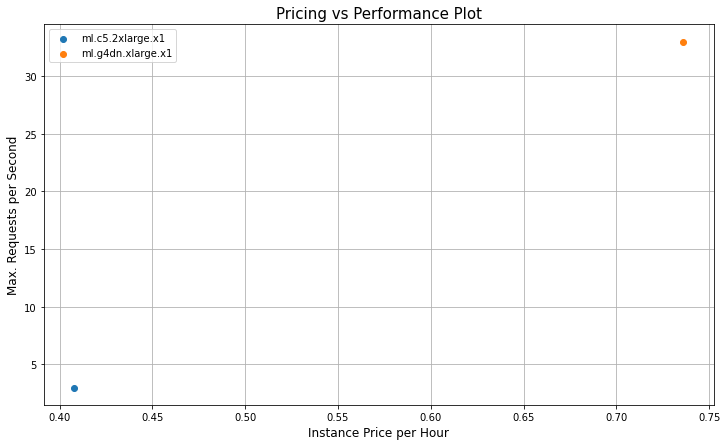

In [37]:
# Deploy the endpoints and plot max requests per second for each endpoint type 

sat_endpoints = deploy_endpoints(sat_endpoints_dict, cpu_model, gpu_model)
sat_results_folder = run_load_tests(api_url, sat_endpoints)
results = generate_plots(sat_endpoints, sat_endpoints_dict, sat_results_folder, sep_cpu_gpu=False)

In [ ]:
# Programmatically get suggested instance type and counts
sa_endpoints_dict = get_min_max_instances(results, min_requests_per_second, max_requests_per_second)

In [ ]:
# Print recommended number of instances based on linear scaling
print("Recommended endpoint configuration for the specified number of requests: ")
print("________________________________________________________________")
print(f"Instance Type: {sa_endpoints_dict[0]['instance_type']}")
print(f"Minimum Instance Count: {sa_endpoints_dict[0]['instance_count']}")
print(f"Maximum Instance Count: {sa_endpoints_dict[1]['instance_count']}")

In the results above, the goal of average rps exceeds both the capacity of the most expensive CPU and the cheapest GPU. In addition, the recommended number/type of instances (assuming linear scaling) favours the GPU rather than the CPU.

In this sense, our exploratory work implies that we need to proceed with a second iteration to see which instances can serve our model properly.

_Note: If you updated the maximum and minimum requests per second, your results may vary._

### Step 2.2.2: Second iteration
<a id='second-iteration'></a>

In this second iteration, since you already found that the CPU instances perform worse, run a test comparing only GPUs.

In the previous test, the `ml.g4dn.xlarge` instance serves up to ~50rps, so assuming a linear scalability, test if using 2 instances in an endpoint will allow it to serve 100rps, to verify linear scaling.

In addition, test the performance of the most expensive GPU (available for this model) to see how it would perform in comparison with the `ml.g4dn.xlarge x 2`. Depending on the results, you can decide if another iteration is required.

In [ ]:
sat_p2_endpoints_dict = [
    {"instance_type": "ml.p3.2xlarge", "instance_count": 1},
    {"instance_type": 'ml.g4dn.xlarge', "instance_count": 2}
]

In [ ]:
# Deploy the endpoints
sat_p2_endpoints = deploy_endpoints(sat_p2_endpoints_dict, cpu_model, gpu_model)

# Run the load tests and organize the data
sat_p2_results_folder = run_load_tests(api_url, sat_p2_endpoints)

# Generate the plots showing the results
results = generate_plots(sat_p2_endpoints, sat_p2_endpoints_dict, sat_p2_results_folder, sep_cpu_gpu=False)

In this case, the `ml.g4dn.xlarge x 2` endpoint managed to deal with 100rps (actually, a bit more), whereas the `ml.p3.2xlarge` started to fail close to 50rps (very similar performance to the `ml.g4dn.xlarge`).

Now, with regards to price, the `ml.g4dn.xlarge x 2` configuration looks like the final choice, in the sense that even though it has 2 instances, its price is even lower than a single instance `ml.p3.2xlarge`.

## Step 3. Clean up Resources
<a id='clean-up'></a>

Remember to delete the endpoints and unsubscribe from AWS Marketplace once your tests are complete to avoid incurring additional daily/monthly costs.

In [ ]:
# delete endpoints from comprehensive testing
clean_up_endpoints(endpoints + phase2_endpoints)

# delete endpoints from semi-automatic testing
clean_up_endpoints(sat_endpoints + sat_p2_endpoints)

If you would like to unsubscribe to the model, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model.

__Steps to unsubscribe to product from AWS Marketplace:___
1. Navigate to __Machine Learning__ tab on [Your Software subscriptions page](https://aws.amazon.com/marketplace/ai/library?productType=ml)
2. Locate the listing that you would need to cancel subscription for, and then choose __Cancel Subscription__ to cancel the subscription.

Note: If you do not delete the endpoint, you will be charged for the model as long as it is in use.

In [62]:
# delete infrastructure created to load test the endpoints
models_list = [cpu_model, gpu_model]
delete_infra(project_name, account_id, rest_api_id, models_list)

IAM Policy deleted.
IAM Role deleted.
Lambda Function request-predictions-right-size-endpoints deleted.
Rest API with id yzlgfq6ek4 deleted.
Error deleting resources: The SageMaker model must be created first before attempting to delete.
Please delete the resources manually to avoid costs.


In [ ]:
rest